In [13]:
import argparse
from pprint import pp
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import json
import os
from omegaconf import OmegaConf
from torch.utils.tensorboard import SummaryWriter

from utils import load_dataset, load_config
from utils import get_model
from utils import get_loss_hparams_and_lr, get_loss
from utils import trainer
from utils import utils
import matplotlib.pyplot as plt

In [14]:
#set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#code in this file will serve as a denoising test of the trained ne_lpn model

dataset_config_path = "../exps/mnist/configs/mnist/test_dataset.json"



In [15]:
def run_test(network_type, scale_factor, model_path, dataset_config_path, model_weight_path):
    # load model and dataset
    model_config = load_config(model_path)
    model = get_model(model_config)
    model.load_state_dict(torch.load(model_weight_path)["model_state_dict"])

    dataset_config = load_config(dataset_config_path)
    test_dataset = load_dataset(dataset_config, "test")

    #get the data loader
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=4
    )

    # test for batches and apply guassian noise to each
    for step, batch in enumerate(test_data_loader):
        clean_images = batch["image"].to(device)
        output_clean = model(clean_images)

        print("Clean Min: ", output_clean.min())
        print("Clean Max: ", output_clean.max())

        scaled_images = clean_images * scale_factor
        output_scaled = model(scaled_images)
        print("Scaled Min: ", output_scaled.min())
        print("Scaled Max: ", output_scaled.max())


        if step == 0:
            #plot the four images ( using matplotlib
            fig, axs = plt.subplots(2, 2)
            axs[0, 0].imshow(clean_images[0][0].cpu().detach().numpy(), cmap='gray')
            axs[0, 0].set_title('Input Image Unscaled')
            axs[0, 0].axis('off')
            axs[0, 1].imshow(output_clean[0][0].cpu().detach().numpy(), cmap='gray')
            axs[0, 1].set_title('Model Output Unscaled')
            axs[0, 1].axis('off')
            axs[1, 0].imshow(scaled_images[0][0].cpu().detach().numpy(), cmap='gray')
            axs[1, 0].set_title('Input Image Scaled')
            axs[1, 0].axis('off')
            axs[1, 1].imshow(output_scaled[0][0].cpu().detach().numpy(), cmap='gray')
            axs[1, 1].set_title('Model Output Scaled')
            axs[1, 1].axis('off')
    

            #test scaled input vs unscaled input using mse
            input_mse_loss = nn.MSELoss()
            input_loss = input_mse_loss(clean_images, scaled_images)
           # print(f"Loss between scaled and unscaled input for network {network_type} and scale {scale_factor}: {input_loss.item()}")
            #test scaled output vs unscaled output using mse
            output_mse_loss = nn.MSELoss()
            output_loss = output_mse_loss(output_clean, output_scaled)
            #print(f"Loss between scaled and unscaled output for network {network_type} and scale {scale_factor}: {output_loss.item()}")

            #test scaled output vs unscaled output times the scaling factor
            output_clean_mult = output_clean * scale_factor
            mse_loss = output_mse_loss(output_clean_mult, output_scaled)

            #below the plot show the mse of the scaled output vs the unscaled output times the scale factor
            plt.suptitle(f"Network: {network_type} | Scale factor: {scale_factor}")   

            # show the text below the plot
            if mse_loss.item() < 0.0001:
                rounded_loss = f"{mse_loss.item():.4e}"
            else:
                rounded_loss = f"{mse_loss.item():.4f}"
            plt.text(0.5, -0.2, f"MSE between scaled output and unscaled output times scale factor: {rounded_loss}", horizontalalignment='center', verticalalignment='center', transform=axs[1, 1].transAxes)
            #show the plot
            plt.show()
            #save the figure
            result_dir = os.path.join("scaling_experiment", network_type)
            if not os.path.exists(result_dir):
                os.makedirs(result_dir)
            fig.savefig(os.path.join(result_dir, f"figure_scale_{scale_factor}.png"), bbox_inches='tight')
            print(f"Loss between scaled and unscaled output times scale factor for network {network_type} and scale {scale_factor}: {mse_loss.item()}")
            break



In [16]:
config_paths = {
    "ne": "../exps/mnist/configs/mnist/model_ne.json",
    "lpn": "../exps/mnist/configs/mnist/model.json",
    "ne_no_affine": "../exps/mnist/configs/mnist/model_ne_mnist_no_affine.json",
    #"ne_no_affine_z": "../exps/mnist/configs/mnist/model_ne_mnist_no_affine_z_scored.json",
    "ne_aff_z": "../exps/mnist/configs/mnist/model_ne_mnist_affine_z_scored.json"
}

weight_paths = {
    "ne": "../exps/mnist/experiments/ne_mnist/model.pt",
    "lpn": "../exps/mnist/experiments/mnist/model.pt",
    "ne_no_affine": "../exps/mnist/experiments/ne_mnist_no_affine/model.pt",
    #"ne_no_affine_z": "../exps/mnist/experiments/ne_mnist_no_affine_z_scored/model.pt",
    "ne_aff_z": "../exps/mnist/experiments/ne_mnist_affine_z_scored/model.pt"
}

dataset_config_path = "../exps/mnist/configs/mnist/test_dataset.json"

In [17]:
scaling_factors = [1, 2, 3]

init weights
dataset:  mnist
Clean Min:  tensor(-0.2351, grad_fn=<MinBackward1>)
Clean Max:  tensor(1.0841, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.2351, grad_fn=<MinBackward1>)
Scaled Max:  tensor(1.0841, grad_fn=<MaxBackward1>)


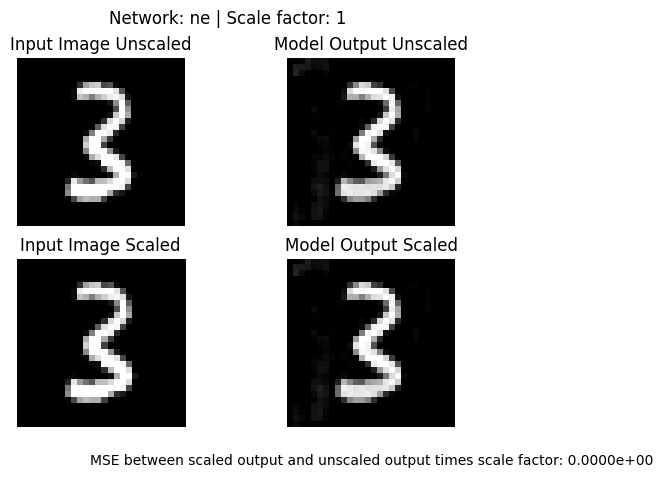

Loss between scaled and unscaled output times scale factor for network ne and scale 1: 0.0
init weights
dataset:  mnist
Clean Min:  tensor(-0.0139, grad_fn=<MinBackward1>)
Clean Max:  tensor(1.0145, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.0139, grad_fn=<MinBackward1>)
Scaled Max:  tensor(1.0145, grad_fn=<MaxBackward1>)


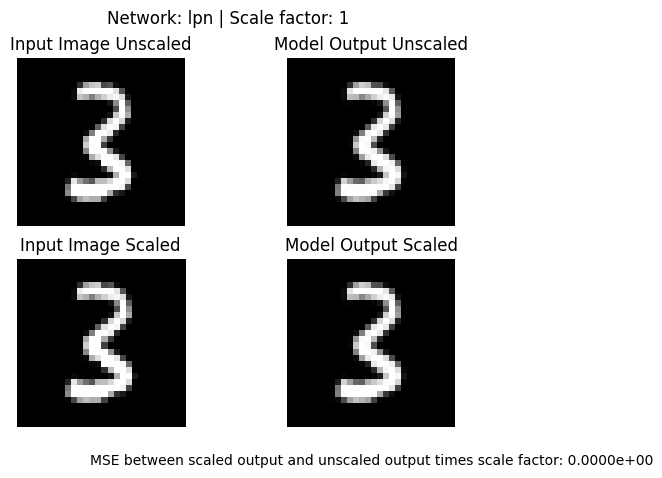

Loss between scaled and unscaled output times scale factor for network lpn and scale 1: 0.0
init weights
dataset:  mnist
Clean Min:  tensor(-0.1352, grad_fn=<MinBackward1>)
Clean Max:  tensor(0.9993, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.1352, grad_fn=<MinBackward1>)
Scaled Max:  tensor(0.9993, grad_fn=<MaxBackward1>)


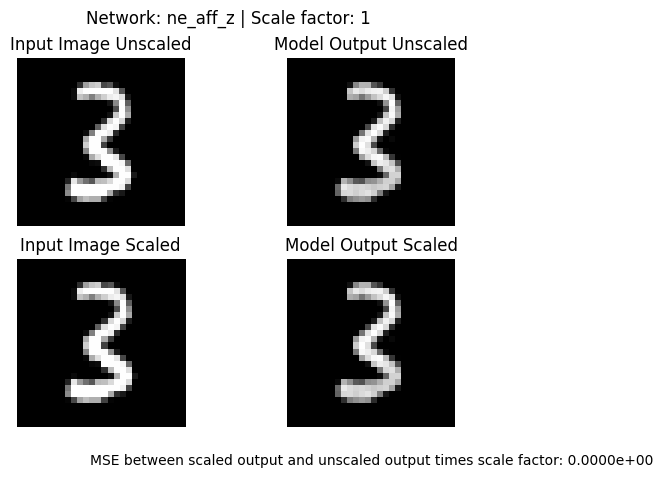

Loss between scaled and unscaled output times scale factor for network ne_aff_z and scale 1: 0.0
init weights
dataset:  mnist
Clean Min:  tensor(-0.2351, grad_fn=<MinBackward1>)
Clean Max:  tensor(1.0841, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.4703, grad_fn=<MinBackward1>)
Scaled Max:  tensor(2.1681, grad_fn=<MaxBackward1>)


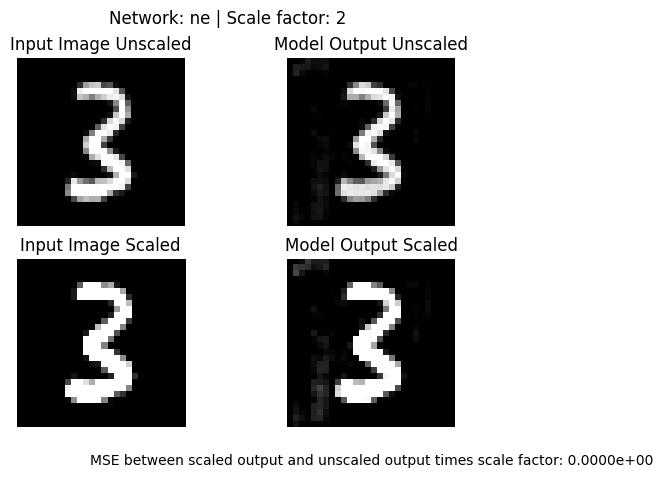

Loss between scaled and unscaled output times scale factor for network ne and scale 2: 0.0
init weights
dataset:  mnist
Clean Min:  tensor(-0.0139, grad_fn=<MinBackward1>)
Clean Max:  tensor(1.0145, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.0345, grad_fn=<MinBackward1>)
Scaled Max:  tensor(1.1696, grad_fn=<MaxBackward1>)


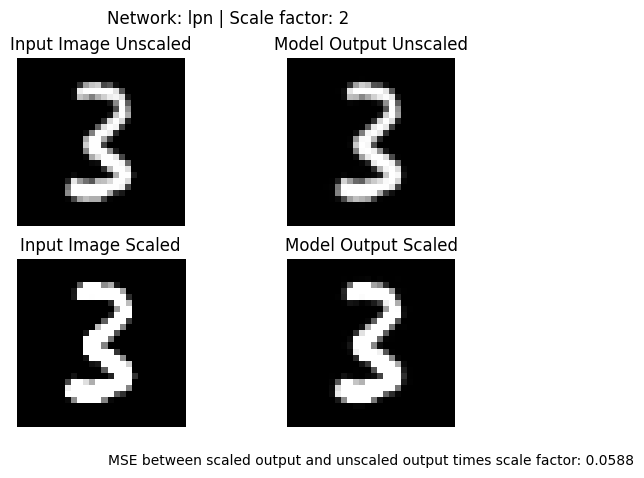

Loss between scaled and unscaled output times scale factor for network lpn and scale 2: 0.058778733015060425
init weights
dataset:  mnist
Clean Min:  tensor(-0.1352, grad_fn=<MinBackward1>)
Clean Max:  tensor(0.9993, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.2705, grad_fn=<MinBackward1>)
Scaled Max:  tensor(1.9986, grad_fn=<MaxBackward1>)


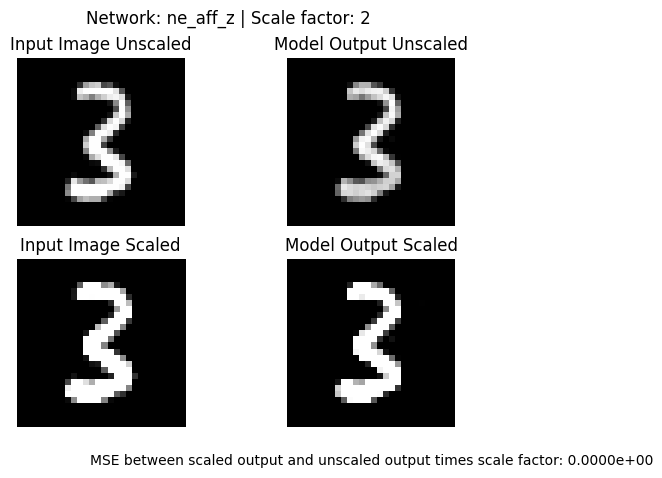

Loss between scaled and unscaled output times scale factor for network ne_aff_z and scale 2: 0.0
init weights
dataset:  mnist
Clean Min:  tensor(-0.2351, grad_fn=<MinBackward1>)
Clean Max:  tensor(1.0841, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.7054, grad_fn=<MinBackward1>)
Scaled Max:  tensor(3.2522, grad_fn=<MaxBackward1>)


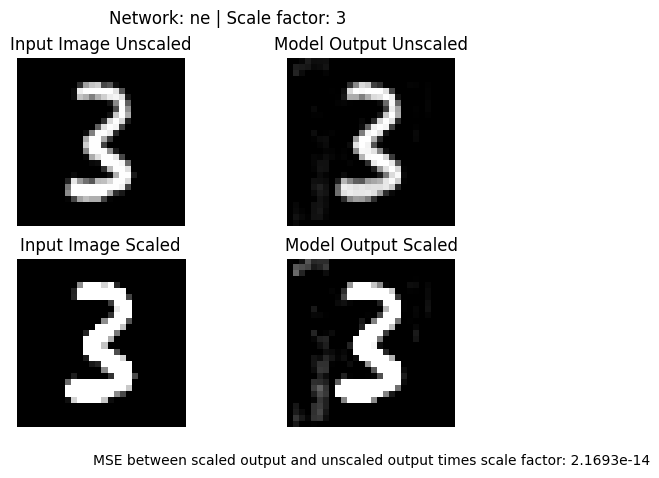

Loss between scaled and unscaled output times scale factor for network ne and scale 3: 2.1692650998520087e-14
init weights
dataset:  mnist
Clean Min:  tensor(-0.0139, grad_fn=<MinBackward1>)
Clean Max:  tensor(1.0145, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.0470, grad_fn=<MinBackward1>)
Scaled Max:  tensor(1.2276, grad_fn=<MaxBackward1>)


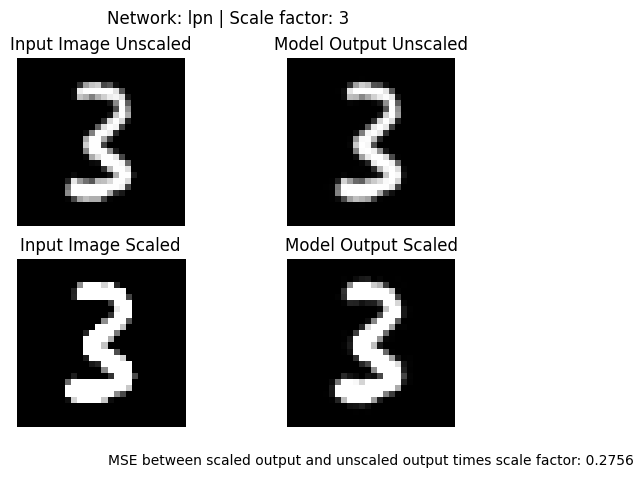

Loss between scaled and unscaled output times scale factor for network lpn and scale 3: 0.27559733390808105
init weights
dataset:  mnist
Clean Min:  tensor(-0.1352, grad_fn=<MinBackward1>)
Clean Max:  tensor(0.9993, grad_fn=<MaxBackward1>)
Scaled Min:  tensor(-0.4203, grad_fn=<MinBackward1>)
Scaled Max:  tensor(2.9980, grad_fn=<MaxBackward1>)


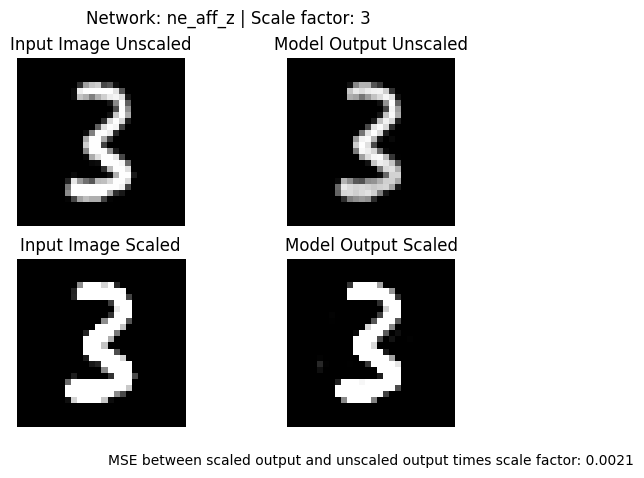

Loss between scaled and unscaled output times scale factor for network ne_aff_z and scale 3: 0.0021313622128218412


In [18]:
for scale_factor in scaling_factors:
    for network_type in config_paths:
        run_test(network_type, scale_factor, config_paths[network_type], dataset_config_path, weight_paths[network_type])